**Performing first trials in jupyter for Tyne and Wear**

**1. Variables declarations**

NB: to be edited depending on who runs this

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

msoa_full_file = "./../data/MSOAs_TyneWear_full.csv"
msoa_list_file = "./../data/MSOAs_TyneWear.csv"
lad_list_file = "./../data/LADs_TyneWear.csv"


house_prices_lsoa_xls_file = "./../data/hpssadataset46medianpricepaidforresidentialpropertiesbylsoa.xls"

greenspace_file = "./../data/gis/OS Open Greenspace (GPKG) GB/data/opgrsp_gb.gpkg"

LSOA_boundaries_file = "./../data/gis/LSOA_(Dec_2011)_Boundaries_Super_Generalised_Clipped_(BSC)_EW_V3/"
MSOA_boundaries_file = ""

output_folder = "./../output/"

**2. Variables import**

A. Tables import

In [2]:
msoas_full_df = pd.read_csv(msoa_full_file)
msoas_list_df = pd.read_csv(msoa_list_file)
lad_list_df = pd.read_csv(lad_list_file)

houseprice_excel_tab = pd.read_excel(house_prices_lsoa_xls_file,
                                     sheet_name = "Data") # name of excel tab within the spreadsheet which contains our desired data


some data edits

In [3]:
# editing the dataframe (contains empty rows and other un-necessary stuff inherited from excel)
# a. first 4 rows are empty
# b. 5th row contains the columns names

houseprice_df_notitle = houseprice_excel_tab.iloc[4:]
houseprice_df_notitle.columns = houseprice_df_notitle.iloc[0]
houseprice_df = houseprice_df_notitle.iloc[1:]

selecting region (case: Tyne and Wear county)

In [4]:
# NOTE: the common field between the houseprice file and regional file is the LAD list
region_LADs_codes_list = lad_list_df["LAD20CD"].to_numpy()

# generating list of LSOAs code for the region
#
# generating list of MSOAs code for the region
#

houseprice_lsoa_region = houseprice_df[houseprice_df["Local authority code"].isin(region_LADs_codes_list)]

In [6]:
# dataframe with LSOAs code and name
lsoas_region_list = houseprice_lsoa_region[["LSOA code", "LSOA name"]]
# creating the list of the region codes for indexing (filtering) purposes
lsoas_region_codes = lsoas_region_list["LSOA code"].to_numpy()

B. Importing geospatial data

In [7]:
# importing greenspace (gpkg)
# note, available layers are: "GreenspaceSite" (green areas) and "AccessPoint" (actual access points)
greenspace = gpd.read_file(greenspace_file,
                           layer = "GreenspaceSite")
greenspace.head() 

,id,function,distinctiveName1,distinctiveName2,distinctiveName3,distinctiveName4,geometry
0,idE56DE736-A177-13A9-E053-AAEFA00A0D0E,Cemetery,None,None,None,None,"MULTIPOLYGON (((461903.000 1202925.500, 461894..."
1,idE56DE70E-AB4D-13A9-E053-AAEFA00A0D0E,Cemetery,None,None,None,None,"MULTIPOLYGON (((456682.070 1204040.270, 456711..."
2,idE56DE70E-A916-13A9-E053-AAEFA00A0D0E,Cemetery,None,None,None,None,"MULTIPOLYGON (((453155.070 1204881.760, 453160..."
3,idE56DE70E-A769-13A9-E053-AAEFA00A0D0E,Religious Grounds,St John's Kirk,None,None,None,"MULTIPOLYGON (((461466.140 1208820.310, 461489..."
4,idE56DE6C9-C6CF-13A9-E053-AAEFA00A0D0E,Play Space,None,None,None,None,"MULTIPOLYGON (((462261.310 1208879.400, 462245..."


<AxesSubplot:>

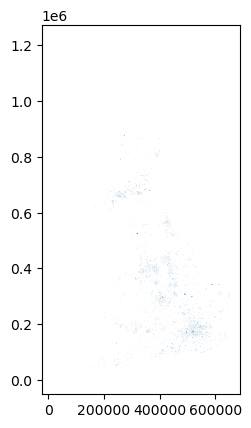

In [8]:
greenspace.plot()

In [9]:
accesspoints_gs = gpd.read_file(greenspace_file,
                           layer = "AccessPoint")
accesspoints_gs.head() 

,id,accessType,refToGreenspaceSite,geometry
0,idB91D85B1-DEE3-47D6-805A-CD6B9ACF4C4F,Pedestrian,idE56DE70E-AB4D-13A9-E053-AAEFA00A0D0E,POINT (456682.070 1204040.270)
1,id4A6E7947-0AFE-48E3-8D42-D4FD1EF4FDEE,Pedestrian,idE56DE70E-A916-13A9-E053-AAEFA00A0D0E,POINT (453155.070 1204881.760)
2,id2614EF8D-E649-4A9F-86F2-95E248B38AFB,Motor Vehicle And Pedestrian,idE56DE70E-A769-13A9-E053-AAEFA00A0D0E,POINT (461466.140 1208820.310)
3,idCC4DDC12-0AE9-4023-A7FE-DE064614A1DC,Pedestrian,idE56DE6C9-C6CF-13A9-E053-AAEFA00A0D0E,POINT (462261.310 1208879.400)
4,idB616B7A5-140F-4564-BDC0-A5AAF61E51AC,Motor Vehicle And Pedestrian,idE56DE70E-A700-13A9-E053-AAEFA00A0D0E,POINT (460892.660 1208953.160)


<AxesSubplot:>

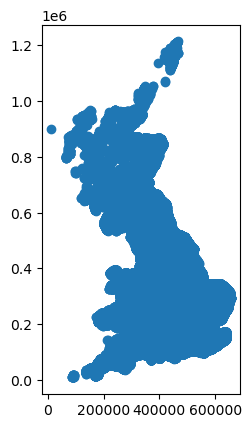

In [10]:
accesspoints_gs.plot()

In [11]:
# importing LSOA admin boundaries (shp or json)
lsoas_shp = gpd.read_file(LSOA_boundaries_file)
lsoas_shp.head()

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.097060,51.51810,157794.481079,1685.391778,b12173a3-5423-4672-a5eb-f152d2345f96,"POLYGON ((532282.629 181906.496, 532248.250 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.091970,51.51868,164882.427628,1804.828196,90274dc4-f785-4afb-95cd-7cc1fc9a2cad,"POLYGON ((532746.814 181786.892, 532248.250 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.095230,51.52176,42219.805717,909.223277,7e89d0ba-f186-45fb-961c-8f5ffcd03808,"POLYGON ((532293.068 182068.422, 532419.592 18..."
3,4,E01000005,City of London 001E,City of London 001E,533581,181265,-0.076280,51.51452,212682.404259,2028.654904,a14c307a-874c-4862-828a-3b1486cc21ea,"POLYGON ((533604.245 181418.129, 533743.689 18..."
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,544994,184276,0.089318,51.53876,130551.387161,1716.896118,65121a2d-3d2b-4935-9712-690f2993cfd2,"POLYGON ((545271.918 184183.948, 545296.314 18..."


In [17]:
# selecting LSOAs from Tyne and Wear
lsoas_shp_region = lsoas_shp.query('LSOA11CD in @lsoas_region_codes')

In [ ]:
lsoas_shp_region.plot()

**3. Data analysis**

Associating data to geospatial data (or viceversa, adding geography to data)